In [15]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from helpers import imshow

In [41]:
def whiteOut(frame):
    #remove white stuff, return a mask of the intsresting stuff
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # define range of white color in HSV
    # change it according to your need !
    sensitivity = 14
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    
    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,frame, mask= mask)
    
    # applying Morphological Operator to the image to clean the image
    kernel = np.ones((3, 3),np.uint8)
    iteration_close = 1
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel,iterations = iteration_close)
    iteration_open = 2
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel,iterations = iteration_open)
    
    # applying Morphological Operator to the image to clean the image
    kernel = np.ones((3, 3),np.uint8)
    iteration_close = 1
    res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel,iterations = iteration_close)
    iteration_open = 2
    res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel,iterations = iteration_open)
    
    return mask,1-res
    #1 - res is what we want, np.multiply(frame,1-res) gives what we want

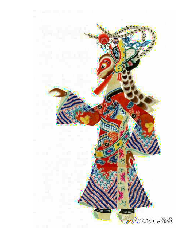

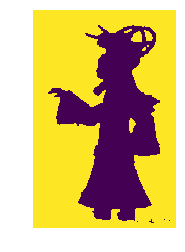

(600, 392, 3)


In [42]:
img1 = cv2.imread("demo.jpg")
mask,res = whiteOut(img1)
#final = np.multiply(img1,mask)
imshow(np.multiply(img1,res))
print(res.shape)